In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from ipyleaflet import Map
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

## Obtain

In [42]:
df_2018 = pd.read_csv('data/Crime_Incidents_in_2018.csv')

In [43]:
df_2019 = pd.read_csv('data/Crime_Incidents_in_2019.csv')

## Data Cleaning

In [44]:
display(df_2018.head(1))
display(df_2019.head(1))

X         Y       CCN                REPORT_DAT    SHIFT  METHOD  \
0 -77.014559  38.94219  18217166  2018-12-22T21:10:50.000Z  EVENING  OTHERS   

       OFFENSE                                 BLOCK    XBLOCK    YBLOCK  ...  \
0  THEFT/OTHER  200  - 299 BLOCK OF UPSHUR STREET NW  398738.0  141588.0  ...   

   BLOCK_GROUP CENSUS_TRACT  VOTING_PRECINCT   LATITUDE  LONGITUDE  BID  \
0     002301 2       2301.0      Precinct 45  38.942182 -77.014557  NaN   

                 START_DATE                  END_DATE   OBJECTID  \
0  2018-12-22T19:12:20.000Z  2018-12-22T19:14:03.000Z  329684676   

   OCTO_RECORD_ID  
0     18217166-01  

[1 rows x 25 columns]

X         Y       CCN                REPORT_DAT SHIFT  METHOD  \
0 -77.017646  38.87787  18220657  2019-01-05T11:31:29.000Z   DAY  OTHERS   

        OFFENSE                              BLOCK    XBLOCK    YBLOCK  ...  \
0  THEFT F/AUTO  900 - 1199 BLOCK OF 4TH STREET SW  398469.0  134448.0  ...   

   BLOCK_GROUP CENSUS_TRACT  VOTING_PRECINCT   LATITUDE  LONGITUDE        BID  \
0     010200 2      10200.0     Precinct 142  38.877862 -77.017644  SOUTHWEST   

                 START_DATE                  END_DATE   OBJECTID  \
0  2018-12-29T14:15:38.000Z  2018-12-29T14:50:43.000Z  330087706   

   OCTO_RECORD_ID  
0     18220657-01  

[1 rows x 25 columns]

In [45]:
print(df_2018.shape)
print(df_2019.shape)

(33782, 25)
(20620, 25)


Let's combine our datasets:

In [46]:
df = df_2018.append(df_2019)
df.shape

(54402, 25)

Let's check for null values in the remaining data: 

In [47]:
df.isna().sum()

X                           0
Y                           0
CCN                         0
REPORT_DAT                  0
SHIFT                       0
METHOD                      0
OFFENSE                     0
BLOCK                       0
XBLOCK                      0
YBLOCK                      0
WARD                        0
ANC                         0
DISTRICT                   13
PSA                        13
NEIGHBORHOOD_CLUSTER      624
BLOCK_GROUP               111
CENSUS_TRACT              111
VOTING_PRECINCT             0
LATITUDE                    0
LONGITUDE                   0
BID                     44138
START_DATE                  0
END_DATE                 9556
OBJECTID                    0
OCTO_RECORD_ID              0
dtype: int64

For the EDA phase, we'll be focusing on the types of crimes committed by geographic location as well as frequency of crimes over time frames. Given this, let's remove some of the unnecessary columns:

In [48]:
df = df.drop(columns=['X', 'Y', 'CCN', 'BLOCK', 'XBLOCK', 'YBLOCK', 'ANC', 'PSA', 
                      'BID', 'START_DATE', 'END_DATE'])

With our dataset slimmed down, let's add a few additional columns to help with our visual analysis in Tableau. We'll add a count measure for totaling crime incidents, as well as a city and state column for Tableau's mapping feature: 

In [49]:
df['COUNT'] = 1

In [50]:
df['CITY'] = 'Washington, DC'

In [51]:
df['STATE'] = 'District of Columbia'

For our time related analysis we'll need to separate the 'REPORT_DAT' column into two separate columns for both the date and time:

In [52]:
new = df['REPORT_DAT'].str.split('T', n=1, expand = True)

In [53]:
new.head()

0              1
0  2018-12-22  21:10:50.000Z
1  2018-12-22  20:29:36.000Z
2  2018-12-23  03:38:37.000Z
3  2018-12-22  21:00:57.000Z
4  2018-12-22  20:49:59.000Z

In [54]:
df['DATE'] = new[0] 

In [55]:
time = new[1].str.split('.', n=1, expand = True)

In [56]:
time.head()

0     1
0  21:10:50  000Z
1  20:29:36  000Z
2  03:38:37  000Z
3  21:00:57  000Z
4  20:49:59  000Z

In [57]:
df['TIME'] = time[0]

In [58]:
df.head()

REPORT_DAT     SHIFT  METHOD              OFFENSE  WARD  \
0  2018-12-22T21:10:50.000Z   EVENING  OTHERS          THEFT/OTHER     4   
1  2018-12-22T20:29:36.000Z   EVENING  OTHERS          THEFT/OTHER     6   
2  2018-12-23T03:38:37.000Z  MIDNIGHT  OTHERS          THEFT/OTHER     7   
3  2018-12-22T21:00:57.000Z   EVENING  OTHERS  MOTOR VEHICLE THEFT     7   
4  2018-12-22T20:49:59.000Z   EVENING  OTHERS         THEFT F/AUTO     2   

   DISTRICT NEIGHBORHOOD_CLUSTER BLOCK_GROUP  CENSUS_TRACT VOTING_PRECINCT  \
0       4.0           Cluster 18    002301 2        2301.0     Precinct 45   
1       1.0           Cluster 27    007200 2        7200.0    Precinct 131   
2       6.0           Cluster 32    009603 3        9603.0    Precinct 102   
3       6.0           Cluster 33    007803 3        7803.0     Precinct 98   
4       1.0            Cluster 8    005800 2        5800.0    Precinct 129   

    LATITUDE  LONGITUDE   OBJECTID OCTO_RECORD_ID  COUNT            CITY  \
0  38.942182 -77.014557  329684676    18217166-01      1  Washington, DC   
1  38.876999 -77.004356  329684677    18217171-01      1  Washington, DC   
2  38.890214 -76.952775  329684678    18217172-01      1  Washington, DC   
3  38.890241 -76.935370  329684679    18217180-01      1  Washington, DC   
4  38.900860 -77.020912  329684680    18217182-01      1  Washington, DC   

                  STATE        DATE      TIME  
0  District of Columbia  2018-12-22  21:10:50  
1  District of Columbia  2018-12-22  20:29:36  
2  District of Columbia  2018-12-23  03:38:37  
3  District of Columbia  2018-12-22  21:00:57  
4  District of Columbia  2018-12-22  20:49:59

Next we'll convert our new 'DATE' column to a datetime data type from it's current object form:

In [59]:
df['DATE'] = pd.to_datetime(df['DATE'], format= '%Y-%m-%d')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54402 entries, 0 to 20619
Data columns (total 19 columns):
REPORT_DAT              54402 non-null object
SHIFT                   54402 non-null object
METHOD                  54402 non-null object
OFFENSE                 54402 non-null object
WARD                    54402 non-null int64
DISTRICT                54389 non-null float64
NEIGHBORHOOD_CLUSTER    53778 non-null object
BLOCK_GROUP             54291 non-null object
CENSUS_TRACT            54291 non-null float64
VOTING_PRECINCT         54402 non-null object
LATITUDE                54402 non-null float64
LONGITUDE               54402 non-null float64
OBJECTID                54402 non-null int64
OCTO_RECORD_ID          54402 non-null object
COUNT                   54402 non-null int64
CITY                    54402 non-null object
STATE                   54402 non-null object
DATE                    54402 non-null datetime64[ns]
TIME                    54402 non-null object
dtypes: 

As a last step, let's address the columns containing the null values. We'll first check the percentage of null values for each column: 

In [61]:
display(df.isna().sum() / len(df) * 100)
display(df.shape)

REPORT_DAT              0.000000
SHIFT                   0.000000
METHOD                  0.000000
OFFENSE                 0.000000
WARD                    0.000000
DISTRICT                0.023896
NEIGHBORHOOD_CLUSTER    1.147017
BLOCK_GROUP             0.204037
CENSUS_TRACT            0.204037
VOTING_PRECINCT         0.000000
LATITUDE                0.000000
LONGITUDE               0.000000
OBJECTID                0.000000
OCTO_RECORD_ID          0.000000
COUNT                   0.000000
CITY                    0.000000
STATE                   0.000000
DATE                    0.000000
TIME                    0.000000
dtype: float64

(54402, 19)

Because the percentage of missing values in our columns are each below 3%, we'll go ahead and remove these rows entirely without losing too much data:

In [62]:
df = df.dropna(axis = 0, how = 'any')

In [63]:
display(df.isna().sum() / len(df) * 100)
display(df.shape)

REPORT_DAT              0.0
SHIFT                   0.0
METHOD                  0.0
OFFENSE                 0.0
WARD                    0.0
DISTRICT                0.0
NEIGHBORHOOD_CLUSTER    0.0
BLOCK_GROUP             0.0
CENSUS_TRACT            0.0
VOTING_PRECINCT         0.0
LATITUDE                0.0
LONGITUDE               0.0
OBJECTID                0.0
OCTO_RECORD_ID          0.0
COUNT                   0.0
CITY                    0.0
STATE                   0.0
DATE                    0.0
TIME                    0.0
dtype: float64

(53654, 19)

Finally, we'll save our cleaned dataset to a new csv file for later use in the modeling portion:

In [64]:
df.to_csv('data/Crime_data_final.csv')

***
## Exploratory Data Analysis

For the exploratory analysis phase, we're going to employ the application Tableau as well as the libraries seaborn and folium to produce meaningful insights into the types of crimes committed, the location of these crimes, as well as the distribution of crime incidents across data/time metrics.

For these graphics, we're going to limit the time frame to July 2018 - July 2019. We start by looking at the number of crimes committed by crime type:

(Note: viewers can hover over the visualizations for additional clarity)

In [65]:
%%HTML

<div class='tableauPlaceholder' id='viz1568299345695' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TotalDCCrime&#47;TotalDCCrime&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TotalDCCrime&#47;TotalDCCrime' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TotalDCCrime&#47;TotalDCCrime&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1568299345695');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='627px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

***
**Time and Date Analysis**

For the time and date analysis, we'll take a look at the total crimes that occurred by month with the percentage change from the previous month.

Next, we break down the number of crime incidents by weekday to see if certain days contain higher crime rates than others. I have included a percent of total calculation for easy comparison.

And finally, we look at the number of crimes committed by hour of day to extract the times at which a crime is most and least likely to occur. 

The graphic below captures the analysis described above:

In [66]:
%%HTML
<div class='tableauPlaceholder' id='viz1568648318015' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;DC&#47;DCCrime_15682540485910&#47;Dashboard8&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='DCCrime_15682540485910&#47;Dashboard8' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;DC&#47;DCCrime_15682540485910&#47;Dashboard8&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1568648318015');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='1827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

***
**Geographic Analysis**

We start the geographical analysis by importing a few maps of DC for easy reference:

DC Map with Parks & Waterways:


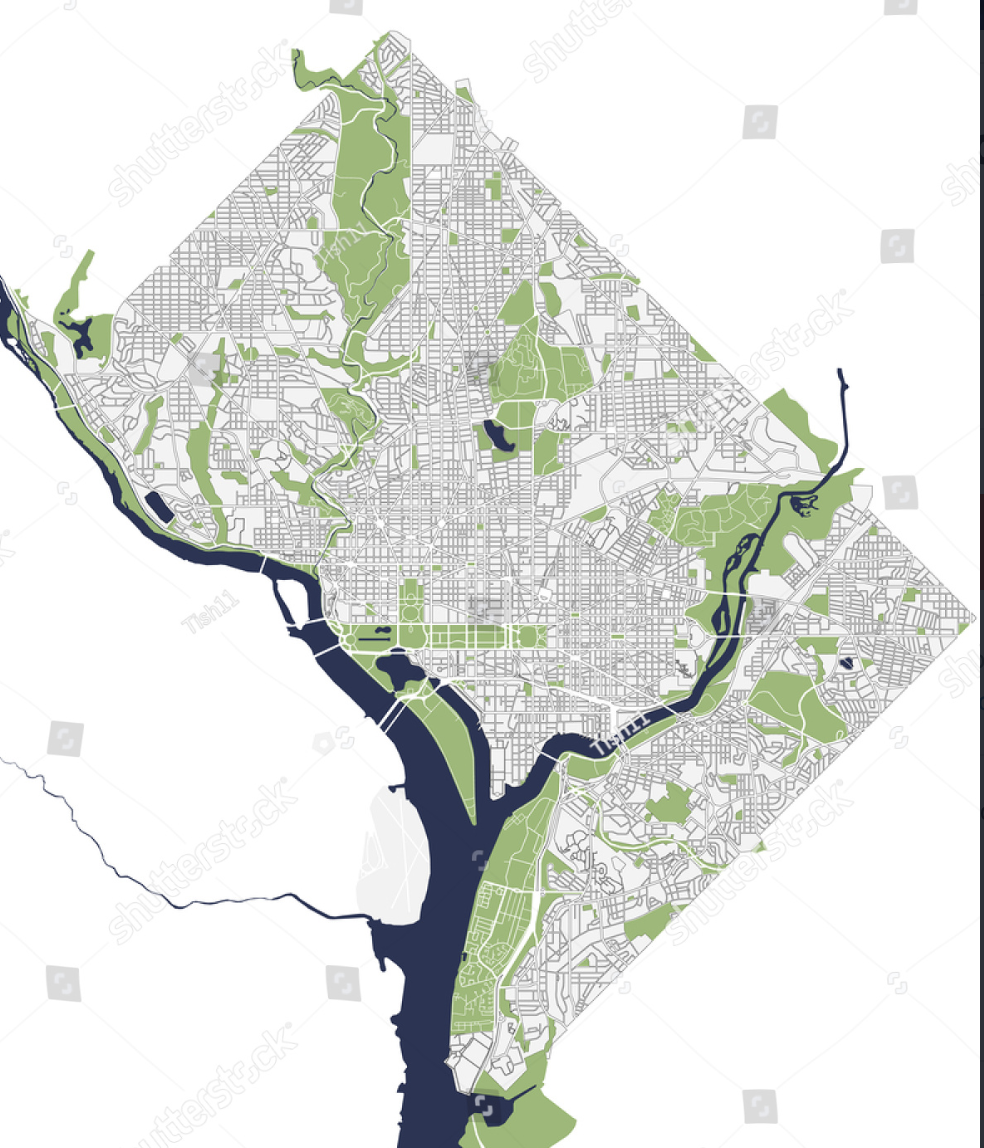

In [67]:
print('DC Map with Parks & Waterways:')

Image(filename = 'Images/DC_map.png',
      width=500, height=500, )

DC Ward Map


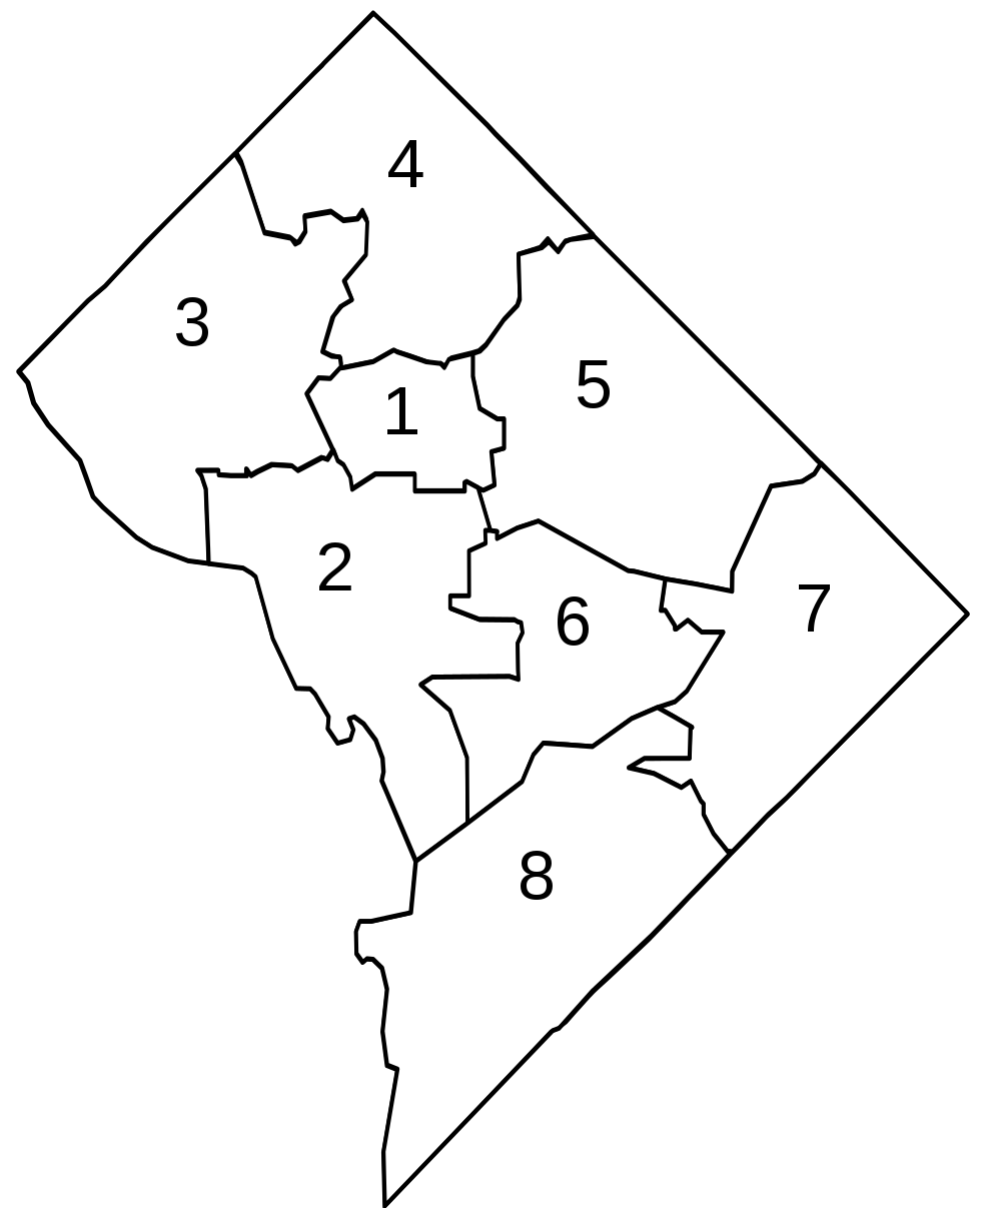

In [68]:
print('DC Ward Map')

Image(filename = 'Images/DC_ward_map.png',
      width=500, height=500, )

We'll generate a map using the folium library for additional geographic reference: 

In [70]:
dc_map = folium.Map(location=[38.9072, -77.0369], zoom_start = 12, tiles = "cartodbpositron")

folium.Marker([38.89722, -77.03654], popup = 'White House').add_to(dc_map)
folium.Marker([38.88968, -77.00937], popup = 'U.S. Capitol').add_to(dc_map)

dc_map

Because our EDA visualizations encompass data from July 2018 - July 2019, we'll need to create a new data frame with the filtered dates for our seaborn/matplotlib visuals. We'll do that now before plotting:

In [71]:
df = pd.read_csv('Data/Crime_data_final.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

In [72]:
df['DATE'] = pd.to_datetime(df['DATE'], format= '%Y-%m-%d')

In [73]:
df_f = df.where((df['DATE'] > '2018-07-31') & (df['DATE'] < '2019-08-01')) 
display(df_f['DATE'].min())
display(df_f['DATE'].max())

Timestamp('2018-08-01 00:00:00')

Timestamp('2019-07-31 00:00:00')

In [74]:
df_f.dropna(inplace=True)

In [75]:
df_f['DATE'] = df_f['DATE'].astype(str)

In [76]:
df_f['YEAR'] = df_f['DATE'].str.split('-').str[0]
df_f['MONTH'] = df_f['DATE'].str.split('-').str[1]
df_f['DAY'] = df_f['DATE'].str.split('-').str[2]

df_f['HOUR'] = df_f['TIME'].str.split(':').str[0]
df_f['MINUTE'] = df_f['TIME'].str.split(':').str[1]
df_f['SECOND'] = df_f['TIME'].str.split(':').str[2]

df_f['YEAR'] = df_f['YEAR'].astype(int)
df_f['MONTH'] = df_f['MONTH'].astype(int)
df_f['DAY'] = df_f['DAY'].astype(int)

df_f['HOUR'] = df_f['HOUR'].astype(int)
df_f['MINUTE'] = df_f['MINUTE'].astype(int)
df_f['SECOND'] = df_f['SECOND'].astype(int)

With the data prepped for plotting, we'll build some heat maps that highlight crime incident concentrations throughout DC:

In [77]:
heat_df = df_f[['MONTH', 'LATITUDE', 'LONGITUDE']]

In [78]:
dc_hm = folium.Map(location=[38.9072, -77.0369], zoom_start = 12, tiles = 'cartodbpositron')

heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in heat_df.iterrows()]

folium.Marker([38.89722, -77.03654], popup = 'White House').add_to(dc_hm)
folium.Marker([38.88968, -77.00937], popup = 'U.S. Capitol').add_to(dc_hm)

#folium.PolyLine(coordinates, color="red", weight=2.5, opacity=1).add_to(dc_hm)
    
HeatMap(heat_data, min_opacity = .3, radius = 8, blur = 10).add_to(dc_hm)

print('Total DC Crime from 7/18 - 7/19')
dc_hm

Total DC Crime from 7/18 - 7/19


Next we animated the headmap to include crimes committed by month:

In [79]:
heat_data_ts = [[[row['LATITUDE'],row['LONGITUDE']] 
              for index, row in heat_df[heat_df['MONTH'] == i].iterrows()] for i in range(1,13)]

In [80]:
dc_hm_ts = folium.Map(location=[38.9072, -77.0369], zoom_start = 12, tiles = 'cartodbpositron')

folium.Marker([38.89722, -77.03654], popup = 'White House').add_to(dc_hm_ts)
folium.Marker([38.88968, -77.00937], popup = 'U.S. Capitol').add_to(dc_hm_ts)

HeatMapWithTime(heat_data_ts, min_opacity = .1, radius = 7).add_to(dc_hm_ts)

dc_hm_ts

Next we separated the geographical distribution for the offense types of most interest. The following graphic looks at the distribtions of theft, homicide, assault with a deadly weapon, burglary, vehicle theft and sex abuse: 

In [81]:
%%HTML

<div class='tableauPlaceholder' id='viz1568652282901' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;DC&#47;DCCrimebyOffense-Heatmap&#47;CrimebyOffenseHeatmaps&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='DCCrimebyOffense-Heatmap&#47;CrimebyOffenseHeatmaps' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;DC&#47;DCCrimebyOffense-Heatmap&#47;CrimebyOffenseHeatmaps&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1568652282901');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='1627px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

We further analyzed crime by wards starting with some basic crime figures: 

In [82]:
%%HTML

<div class='tableauPlaceholder' id='viz1567788560277' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TotalCrimebyWardAnalysis&#47;DCRimebyWardAnalysis&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TotalCrimebyWardAnalysis&#47;DCRimebyWardAnalysis' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;To&#47;TotalCrimebyWardAnalysis&#47;DCRimebyWardAnalysis&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1567788560277');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Now we can plot our data filtered by the appropriate dates. Let's start by plotting every crime committed by ward for the the 12 months ending 8/1/2019:

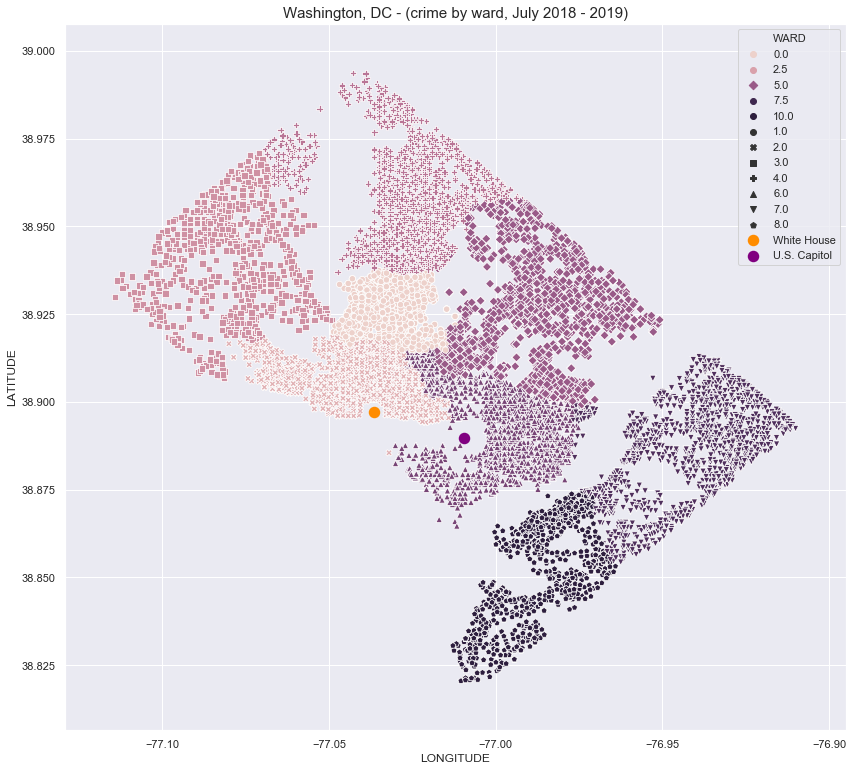

In [83]:
plt.figure(figsize=(14, 13))
sns.set(font_scale=1)

sns.scatterplot(df['LONGITUDE'], df['LATITUDE'], s=40, hue = df_f['WARD'], style = df_f['WARD'], lw=1)

plt.scatter(-77.03654,38.89722, s = 90, color = 'darkorange', lw=2, label = 'White House')
plt.scatter(-77.00937,38.88968,s = 90, color = 'purple', lw=2, label = 'U.S. Capitol')

plt.title('Washington, DC - (crime by ward, July 2018 - 2019)', size = 15)
plt.legend()
plt.show()

And finally, we visualize the month, location and type of crime committed with adjustable parameters between July '18 - '19:

In [85]:
%%HTML
<div class='tableauPlaceholder' id='viz1568655291539' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;In&#47;IncidentMap_15686551429520&#47;MapCrimebyOffense&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='IncidentMap_15686551429520&#47;MapCrimebyOffense' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;In&#47;IncidentMap_15686551429520&#47;MapCrimebyOffense&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1568655291539');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>